In [22]:
from __future__ import print_function

In [23]:
import sys
sys.path.append('../')
sys.path.append('../../build/')

In [24]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [25]:
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator

In [26]:
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver

# Ground truth motor

In [27]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
print(motor)
print(noise_motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 1 0 0.031 0 0.0048 0.005 0.0052 -0.00016 ]


# Dataset

In [42]:
n_points = 10
sigma = 0.09
points_a = [(vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null(),
             vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()  )
            for i in range(n_points)]

points_a_noisy = [(vsr.Vec(*(np.array(a)[:3] + sigma * np.random.randn(3))).null(),
                   vsr.Vec(*(np.array(b)[:3] + sigma * np.random.randn(3))).null()) 
                  for a,b in points_a]

lines_a = [vsr.Dll(a,b).unit() for (a,b) in points_a]
lines_b = [line.spin(motor) for line in lines_a]

In [43]:
lines_a_noisy = [vsr.Dll(a,b).unit() for (a,b) in points_a_noisy]
lines_b_noisy = [line.spin(motor) for line in lines_a_noisy]

In [44]:
lines_b_noisy = [line.spin(motor).spin(noise_motor) for line in lines_a]

# Estimate motor
## No noise

### 6 residuals

In [54]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res, summary_lines_6_res, _) = mes.solve()
print(summary_lines_6_res['brief_report'])
print(em_lines_6_res)

Ceres Solver Report: Iterations: 5, Initial cost: 1.883237e+01, Final cost: 1.086445e-23, Termination: CONVERGENCE
Mot: [ 0.87 -1.2e-13 -0.5 1.2e-13 -0.68 -0.43 -0.18 -0.25 ]


In [55]:
np.allclose(em_lines_6_res, motor)

True

### 4 residuals

In [56]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_4_res, summary_lines_4_res, _) = mes.solve()
print(summary_lines_4_res['brief_report'])
print(em_lines_4_res)

Ceres Solver Report: Iterations: 5, Initial cost: 6.891470e+00, Final cost: 6.847287e-16, Termination: CONVERGENCE
Mot: [ 0.87 5e-10 -0.5 -1.6e-09 -0.68 -0.43 -0.18 -0.25 ]


In [57]:
np.allclose(em_lines_4_res, motor)

True

### Plots

In [47]:
sns.set_style('whitegrid')
sns.set_context('paper')

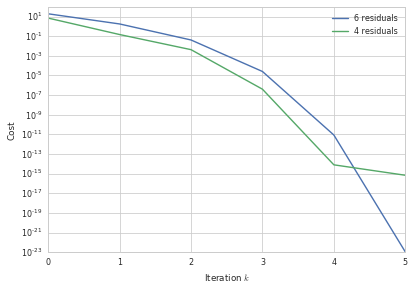

In [48]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_lines_6_res['iterations'])['cost'], label=r'6 residuals')
ax.plot(pd.DataFrame(summary_lines_4_res['iterations'])['cost'], label=r'4 residuals')
# plt.axhline(y=summary_vd['iterations'][0]['cost'])

# ax.plot([it['cost'] for it in summary_point_1_res['iterations']])
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('lines-nonoise.pdf')

## Noise

### 6 residuals

In [49]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b_noisy):
    mes.add_line_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res_noise, summary_lines_6_res_noise, _) = mes.solve()
print(summary_lines_6_res['brief_report'])
print(em_lines_6_res_noise)

Ceres Solver Report: Iterations: 5, Initial cost: 1.883237e+01, Final cost: 1.086445e-23, Termination: CONVERGENCE
Mot: [ 0.88 -4.7e-14 -0.47 7.1e-14 -0.68 -0.44 -0.16 -0.23 ]


### 4 residuals

In [63]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b_noisy):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_4_res_noise, summary_lines_4_res_noise, _) = mes.solve()
print(summary_lines_4_res_noise['brief_report'])
print(em_lines_4_res_noise)

Ceres Solver Report: Iterations: 6, Initial cost: 6.561049e+00, Final cost: 2.340054e-17, Termination: CONVERGENCE
Mot: [ 0.88 -2.9e-09 -0.47 2.9e-09 -0.68 -0.44 -0.16 -0.23 ]


In [64]:
np.allclose(em_lines_6_res_noise, em_lines_4_res_noise)

True

### Valkenburg and Dorst

In [61]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(lines_a,lines_b_noisy)
vd_em_lines_noise = vd.solve()
print(vd_em_lines_noise)

Mot: [ -0.88 1.7e-17 0.47 3.2e-18 0 0 0 0 ]


In [62]:
vd = VDMotorEstimationSolver()
vd.add_dual_line_observations(lines_a,lines_b)
vd_em_lines = vd.solve()
print(vd_em_lines)

Mot: [ -0.87 3.1e-17 0.5 7.2e-18 0 0 0 0 ]


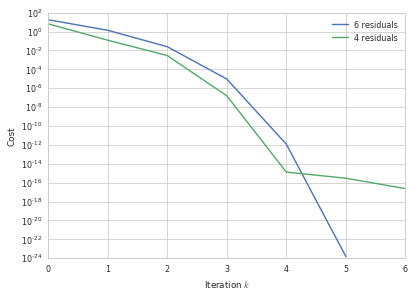

In [52]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary_lines_6_res_noise['iterations'])['cost'], label=r'6 residuals')
ax.plot(pd.DataFrame(summary_lines_4_res_noise['iterations'])['cost'], label=r'4 residuals')
# plt.axhline(y=summary_vd['iterations'][0]['cost'])

# ax.plot([it['cost'] for it in summary_point_1_res['iterations']])
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')
# plt.savefig('lines-noise.pdf')

# Visualization

In [68]:
scene = Scene(children=
#               [line_mesh(line,color=Colors.HOTPINK) for line in lines_a[:2]] +\
              [line_mesh(line,color=Colors.LIGHTSKYBLUE) for line in lines_b[:2]] +\
              [line_mesh(line,color='palegreen') for line in lines_b_noisy[:2]] +\
              
#               [line_mesh(line.spin(vd_em_lines),color=Colors.DEEPPINK) for line in lines_a[:2]] +\
              [line_mesh(line.spin(em_lines_6_res_noise), color=Colors.HOTPINK) for line in lines_a[:2]] +\
              [frame_mesh(),AmbientLight(color='#cccccc')])

camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white',
                    width='960',
                    height='512')
renderer.width = '1024'
renderer.height = '768'
display(renderer)